In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table, hstack
from myspace import MySpace
from sklearn.mixture import GaussianMixture


In [2]:
gaia = Table.read('CombinedRV.fits', format='fits')

In [3]:
qindx=(gaia['bp_rp']<1.5)*(gaia['phot_g_mean_mag']<14.5)*(gaia['parallax']/gaia['parallax_error']>4.)*(gaia['parallax_error']<0.1)*(gaia['visibility_periods_used']>5.)*(gaia['phot_bp_rp_excess_factor']<1.3)*(gaia['phot_bp_rp_excess_factor']>1.172)


//anaconda3/lib/python3.7/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
//anaconda3/lib/python3.7/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


In [22]:
def make_anim2(XX,VV,tensorsx,myspacex,tensorsxv,myspacexv,gs=150):
    
    
    _cyl = gal.represent_as('cylindrical')
    mask2_r500 = (_cyl.rho < 500*u.pc) & (np.abs(_cyl.z) < 500*u.pc) & (_cyl.rho > 200*u.pc)
    disk_vmask2=(np.sqrt(VV[:,0]**2+VV[:,1]**2+VV[:,2]**2)<200.)
    
    rindx=(disk_vmask2)*(mask2_r500)
    for i in range(0,36):
        wedgedex=rindx*(_cyl.phi+np.pi*u.rad>(i*np.pi/18.)*u.rad)*(_cyl.phi+np.pi*u.rad<((i+3)*np.pi/18.)*u.rad)
        if i==34:
            wedgedex=rindx*(_cyl.phi+np.pi*u.rad>(i*np.pi/18.)*u.rad)*(_cyl.phi+np.pi*u.rad<((i+3)*np.pi/18.)*u.rad)+rindx*(_cyl.phi+np.pi*u.rad>0.)*(_cyl.phi+np.pi*u.rad<((1)*np.pi/18.)*u.rad)
        if i==35:
            wedgedex=rindx*(_cyl.phi+np.pi*u.rad>(i*np.pi/18.)*u.rad)*(_cyl.phi+np.pi*u.rad<((i+3)*np.pi/18.)*u.rad)+rindx*(_cyl.phi+np.pi*u.rad>0.)*(_cyl.phi+np.pi*u.rad<((2)*np.pi/18.)*u.rad)
        print(wedgedex.sum(),'stars in wedge',i)

        fixx=myspacex.get_model_v(tensorsx,VV[wedgedex],XX[wedgedex])
        fixxv=myspacexv.get_model_v(tensorsxv,VV[wedgedex],XX[wedgedex])

        f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(15,15))
        ax1.hist2d(XX[:,0][wedgedex],XX[:,1][wedgedex],range=[[-500,500],[-500.,500.]],bins=gs,cmin=1.0e-50,rasterized=True,density=True)
        ax1.set_xlabel(r'$X\ (\mathrm{kpc})$',fontsize=20)
        ax1.set_ylabel(r'$Y\ (\mathrm{kpc})$',fontsize=20)
        ax1.set_xlim(-500.,500.)
        ax1.set_ylim(-500.,500.)
        ax1.set_title(r'$\mathrm{Selected\ area}$',fontsize=20)
        ax2.hist2d(VV[:,0][wedgedex],VV[:,1][wedgedex],range=[[-125,125],[-125,125]],bins=gs,cmin=1.0e-50,rasterized=True,density=True)
        ax2.set_xlabel(r'$v_X\ (\mathrm{km\ s}^{-1})$',fontsize=20)
        ax2.set_ylabel(r'$v_Y\ (\mathrm{km\ s}^{-1})$',fontsize=20)
        ax2.set_xlim(-125,125)
        ax2.set_ylim(-125,125)
        ax2.set_title(r'$\mathrm{No\ correction}$',fontsize=20)
        ax3.hist2d(fixx[:,0],fixx[:,1],range=[[-125,125],[-125,125]],bins=gs,cmin=1.0e-50,rasterized=True,density=True)
        ax3.set_xlabel(r'$v_X\ (\mathrm{km\ s}^{-1})$',fontsize=20)
        ax3.set_ylabel(r'$v_Y\ (\mathrm{km\ s}^{-1})$',fontsize=20)
        ax3.set_xlim(-125,125)
        ax3.set_ylim(-125,125)
        ax3.set_title(r'$\mathrm{x\ correction}$',fontsize=20)
        ax4.hist2d(fixxv[:,0],fixxv[:,1],range=[[-125,125],[-125,125]],bins=gs,cmin=1.0e-50,rasterized=True,density=True)
        ax4.set_xlabel(r'$v_X\ (\mathrm{km\ s}^{-1})$',fontsize=20)
        ax4.set_ylabel(r'$v_Y\ (\mathrm{km\ s}^{-1})$',fontsize=20)
        ax4.set_xlim(-125,125)
        ax4.set_ylim(-125,125)
        ax4.set_title(r'$\mathrm{xv\ correction}$',fontsize=20)
        ax1.tick_params(axis='both', which='major', labelsize=15)
        ax2.tick_params(axis='both', which='major', labelsize=15)
        ax3.tick_params(axis='both', which='major', labelsize=15)
        ax4.tick_params(axis='both', which='major', labelsize=15)
        plt.savefig('gaiao'+str("{:02d}".format(i))+'.pdf',bbox_inches='tight')
        plt.close()

    os.system('convert -delay 5 -loop 0 gaiao*.pdf orders.gif')

In [5]:
c = coord.SkyCoord(ra=gaia['ra'][qindx]*u.deg,dec=gaia['dec'][qindx]*u.deg,distance=1./gaia['parallax'][qindx]*u.kpc,pm_ra_cosdec=gaia['pmra'][qindx]*u.mas/u.yr,pm_dec=gaia['pmdec'][qindx]*u.mas/u.yr,radial_velocity=gaia['radial_velocity'][qindx]*u.km/u.s)
galcen = c.transform_to(coord.Galactocentric())

In [6]:
gal = c.galactic
gal.set_representation_cls('cartesian')

In [13]:
xyz = np.vstack((gal.u.to(u.pc).value, 
                 gal.v.to(u.pc).value,
                 gal.w.to(u.pc).value)).T

UVW = np.vstack((gal.U.to(u.km/u.s).value, 
                 gal.V.to(u.km/u.s).value, 
                 gal.W.to(u.km/u.s).value)).T

disk_vmask = np.linalg.norm(UVW, axis=1) < 200.

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


In [14]:
XX=xyz
VV=UVW
dist2=np.sqrt(XX[:,0]**2+XX[:,1]**2)

_cyl = gal.represent_as('cylindrical')
mask_r100 = (_cyl.rho < 100*u.pc) & (np.abs(_cyl.z) < 150*u.pc)
mask_r300 = (_cyl.rho < 300*u.pc) & (np.abs(_cyl.z) < 500*u.pc)
mask_r500 = (_cyl.rho < 500*u.pc) & (np.abs(_cyl.z) < 500*u.pc)
mask_r100.sum(), mask_r500.sum()
#local_mask=(dist2<0.2)*(np.fabs(XX[:,2])<0.2)
#train_mask=(dist2>0.2)*(dist2<0.5)*(np.fabs(XX[:,2])<0.5)

local_v = UVW[disk_vmask & mask_r100]
local_x = xyz[disk_vmask & mask_r100]

print(local_v.shape)

(71837, 3)


In [15]:
local_gmm = GaussianMixture(n_components=16)
local_gmm.fit(local_v)

GaussianMixture(n_components=16)

In [16]:
myspace = MySpace(local_gmm, terms=['x'])
myspacexv = MySpace(local_gmm, terms=['x','xv'])

In [17]:

train_v = UVW[disk_vmask & mask_r300]
train_x = xyz[disk_vmask & mask_r300]

test_v = UVW[disk_vmask & mask_r500]
test_x = xyz[disk_vmask & mask_r500]

local_v.shape, train_v.shape, test_v.shape

((71837, 3), (892013, 3), (1647258, 3))

In [18]:
res, tensors = myspace.fit(train_x, train_v)
resxv, tensorsxv = myspacexv.fit(train_x, train_v)
print(tensors,tensorsxv)

{'Aij': array([[-0.00193637, -0.02503655,  0.00260833],
       [-0.01677368, -0.00115208,  0.00021614],
       [-0.00115566, -0.00091221,  0.00030888]])} {'Aij': array([[-0.01032493, -0.02425539,  0.01079064],
       [-0.01724293, -0.00288761,  0.00616705],
       [-0.01041469, -0.00346526,  0.01222625]]), 'Bijl': array([[[-9.10315193e-04,  3.33588818e-04, -1.92840642e-06],
        [-1.83516706e-04,  2.11274410e-04, -3.80528228e-05],
        [ 1.04138986e-03, -4.46144204e-04,  1.76770057e-04]],

       [[ 2.77473165e-04, -9.31222597e-04, -7.23587381e-05],
        [ 1.14313732e-04, -3.27502321e-04,  1.22911268e-05],
        [-2.55871314e-04,  1.22618540e-03,  5.68783720e-05]],

       [[ 1.37755119e-05, -4.36246851e-05, -1.34898778e-03],
        [-4.99925952e-06, -6.82422417e-07, -3.84730064e-04],
        [ 3.76469433e-05,  2.65024471e-05,  1.68010307e-03]]])}


In [19]:
fixx=myspace.get_model_v(tensors,test_v,test_x)
fixxv=myspacexv.get_model_v(tensorsxv,test_v,test_x)

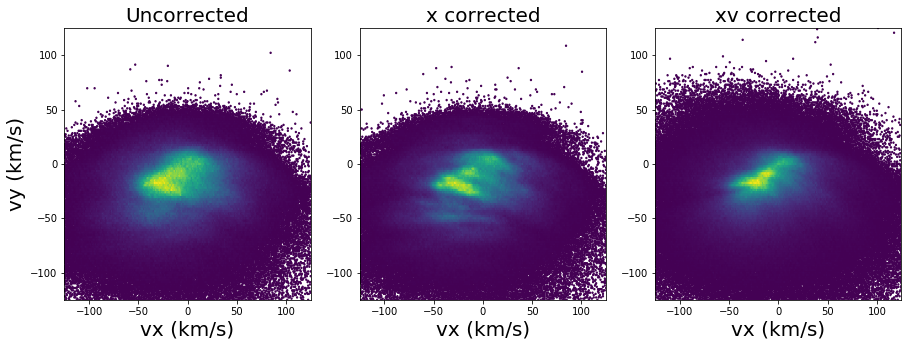

In [24]:
f, ((ax1,ax2,ax3)) = plt.subplots(1, 3, figsize=(15,5))
gs=200
ax1.hexbin(test_v[:,0],test_v[:,1],extent=[-125,125,-125,125],mincnt=1,rasterized=True,gridsize=gs)
ax1.set_title('Uncorrected',fontsize=20)
ax1.set_xlabel('vx (km/s)',fontsize=20)
ax1.set_ylabel('vy (km/s)',fontsize=20)
ax1.set_xlim(-125,125)
ax1.set_ylim(-125,125)
ax2.hexbin(fixx[:,0],fixx[:,1],extent=[-125,125,-125,125],mincnt=1,rasterized=True,gridsize=gs)
ax2.set_title('x corrected',fontsize=20)
ax2.set_xlabel('vx (km/s)',fontsize=20)
ax2.set_xlim(-125,125)
ax2.set_ylim(-125,125)
ax3.hexbin(fixxv[:,0],fixxv[:,1],extent=[-125,125,-125,125],mincnt=1,rasterized=True,gridsize=gs)
ax3.set_title('xv corrected',fontsize=20)
ax3.set_xlabel('vx (km/s)',fontsize=20)
ax3.set_xlim(-125,125)
ax3.set_ylim(-125,125)
plt.show()

In [23]:
make_anim2(XX,VV,tensors,myspace,tensorsxv,myspacexv)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


86201 stars in wedge 0
89301 stars in wedge 1
90204 stars in wedge 2
92303 stars in wedge 3
94224 stars in wedge 4
96232 stars in wedge 5
98351 stars in wedge 6
101063 stars in wedge 7
103957 stars in wedge 8
104088 stars in wedge 9
104423 stars in wedge 10
103990 stars in wedge 11
107656 stars in wedge 12
109620 stars in wedge 13
109387 stars in wedge 14
103866 stars in wedge 15
96235 stars in wedge 16
90930 stars in wedge 17
89011 stars in wedge 18
94180 stars in wedge 19
100691 stars in wedge 20
106906 stars in wedge 21
109724 stars in wedge 22
110355 stars in wedge 23
111348 stars in wedge 24
110111 stars in wedge 25
108137 stars in wedge 26
104399 stars in wedge 27
100494 stars in wedge 28
98024 stars in wedge 29
94557 stars in wedge 30
90795 stars in wedge 31
85977 stars in wedge 32
79574 stars in wedge 33
78090 stars in wedge 34
80376 stars in wedge 35
